## Library Imports

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix


import itertools
import os
import shutil
import random
from time import time
import matplotlib.pyplot as plt
#import pillow as pil
%matplotlib inline


In [13]:
DATA_PATH = 'SampleData'
NUM_LAYERS_TO_REMOVE = 6
NUM_LAYERS_TO_TRAIN = 20


## Build Model for Fine-Tuning

In [3]:
mobile_v3 = tf.keras.applications.MobileNetV3Large()

In [4]:
# Function to preprocess the image with Keras

def image_preprocessing(file):
    img_path = DATA_PATH + '/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet_v3.preprocess_input(img_array_expanded_dims)

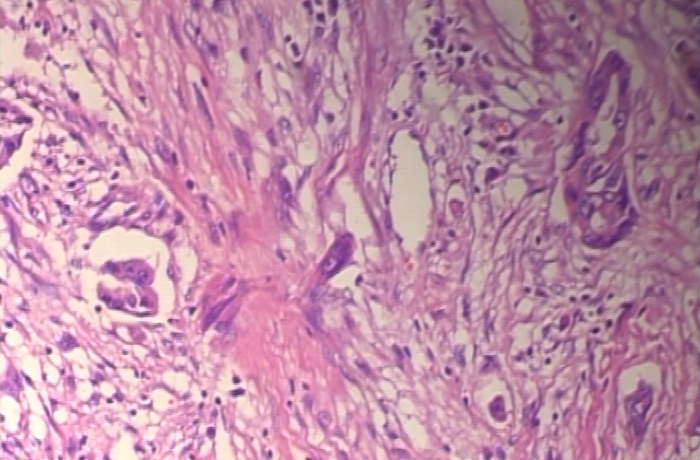

In [5]:
# Display test image

from IPython.display import Image
Image(filename='SampleData/SOB_M_DC-14-10926-100-002.png', width=300,height=200)

#test_image = 'SOB_M_DC-14-10926-100-002.png'



In [10]:
preprocessed_image = image_preprocessing('SOB_M_DC-14-10926-100-002.png')
predictions = mobile_v3.predict(preprocessed_image)
print("Output shape: ", predictions.shape)
results = imagenet_utils.decode_predictions(predictions)
results

1/1 [==============================] - 0s 384ms/step
Output shape:  (1, 1000)


[[('n01774750', 'tarantula', 0.16532774),
  ('n03980874', 'poncho', 0.05259283),
  ('n02346627', 'porcupine', 0.022364149),
  ('n01775062', 'wolf_spider', 0.01801954),
  ('n12985857', 'coral_fungus', 0.017100263)]]

In [11]:
mobile_v3.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, None, None, 16)       432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, None, None, 16)       64        ['Conv[0][0]']                
 lization)                                                                         

Remove the specifiied number of layers.
Freeze the specified number of layers.

In [14]:
# Remove last layers
x = mobile_v3.layers[-NUM_LAYERS_TO_REMOVE].output
output = Dense(units=2, activation='softmax')(x)

# Create new model
new_model = Model(inputs=mobile_v3.input, outputs=output)

# Freeze layers
for layer in new_model.layers[:-NUM_LAYERS_TO_TRAIN]:
    layer.trainable = False

print(new_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, None, None, 16)       432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, None, None, 16)       64        ['Conv[0][0]']                
 lization)                                                                                    

## Train New Model

## Evaluate Model

In [19]:
# Decorator for timing functions
def timer(method):
    def timed(*args, **kw):
        time_start = time()
        result = method(*args, **kw)
        time_end = time()
        print(f'{method.__name__} took: {time_end-time_start} sec')
        return result
    return timed

In [20]:
# Test prediciton on single image

@timer
def predict_single_image(model, image):
    preprocessed_image = image_preprocessing(image)
    predictions = model.predict(preprocessed_image)
    return predictions

predict_single_image(new_model, 'SOB_M_DC-14-10926-100-002.png')

1/1 [==============================] - 0s 54ms/step
predict_single_image took: 0.13213515281677246 sec


array([[[[0.51136595, 0.48863396]]]], dtype=float32)